这里做一些图像降噪的算法可视化，研究。原文来自[这里](https://www.kaggle.com/jgroff/despeckling-synthetic-aperture-radar-sar-images/notebook)

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter


train_data = pd.read_json('D:/dataset/kaggle_Iceberg/train.json')
train_data.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


我们先对原始图片进行显示，通过图片，可以看到图片存在很多噪声。

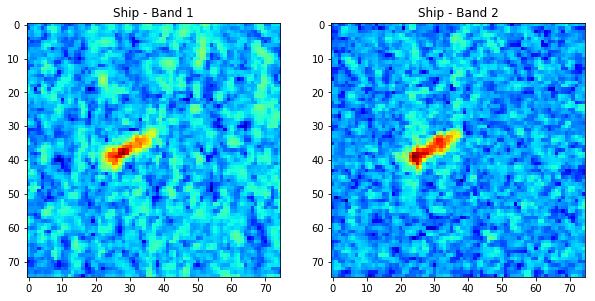

In [2]:
row = train_data.sample(1)
title_str = 'Iceberg' if row['is_iceberg'].values == 1 else 'Ship'

band_1= np.reshape(row['band_1'].values.tolist(),(75,75))
band_2= np.reshape(row['band_2'].values.tolist(),(75,75))

fig = plt.figure(0, figsize=(10,10))
ax = fig.add_subplot(1,2,1)
ax.set_title(title_str + ' - Band 1')
ax.imshow(band_1,cmap='jet')
ax = fig.add_subplot(1,2,2)
ax.set_title(title_str + ' - Band 2')
ax.imshow(band_2,cmap='jet')
plt.show()

原始图像带数据以分贝为单位给出，所以我将转换为线性单位，假设原始数据由下式给出：Z（dB）= 10log10（Z / Z_0）并且Z_0是1。

In [3]:
# 将SAR数据从分贝单位转换成线性单位，然后再返回
def decibel_to_linear(band):
    return np.power(10,np.array(band)/10)

def linear_to_decibel(band):
    return 10*np.log10(band)

现在让我们看看在转化为线性单位之后，上面的图像是一样的。 斑点噪声在某些图像中很难看出，因为像素值的范围远大于噪声方差，这在所有图像中可能大致相同（至少以dB为单位）。

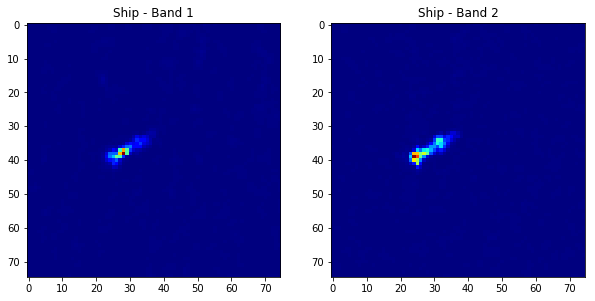

In [4]:
band_1_linear = decibel_to_linear(band_1)
band_2_linear = decibel_to_linear(band_2)

fig = plt.figure(1, figsize=(10,10))
ax = fig.add_subplot(1,2,1)
ax.set_title(title_str + ' - Band 1')
ax.imshow(band_1_linear,cmap='jet')
ax = fig.add_subplot(1,2,2)
ax.set_title(title_str + ' - Band 2')
ax.imshow(band_2_linear,cmap='jet')
plt.show()

Lee 滤波器

In [5]:
# implement the Lee Filter for a band in an image already reshaped into the proper dimensions
def lee_filter(band, window, var_noise = 0.25):
        # band: SAR data to be despeckled (already reshaped into image dimensions)
        # window: descpeckling filter window (tuple)
        # default noise variance = 0.25
        # assumes noise mean = 0
    
        mean_window = uniform_filter(band, window)
        mean_sqr_window = uniform_filter(band**2, window)
        var_window = mean_sqr_window - mean_window**2

        weights = var_window / (var_window + var_noise)
        band_filtered = mean_window + weights*(band - mean_window)
        return band_filtered

In [6]:
# let's see if despeckling has any influence on the images
# plot nine different instances with different windows and noise levels (band 1)
windows = [2, 4, 8] # can be tuple too if not symetric
noise_var = np.array([1, 2, 4])

title_str_1 = title_str + ' Band 1\nWindow: {}, Noise Var: {}'
title_str_2 = title_str + ' Band 2\nWindow: {}, Noise Var: {}'

noise_var_1 = np.round(np.var(band_1_linear)*noise_var,10)
noise_var_2 = np.round(np.var(band_2_linear)*noise_var,10)

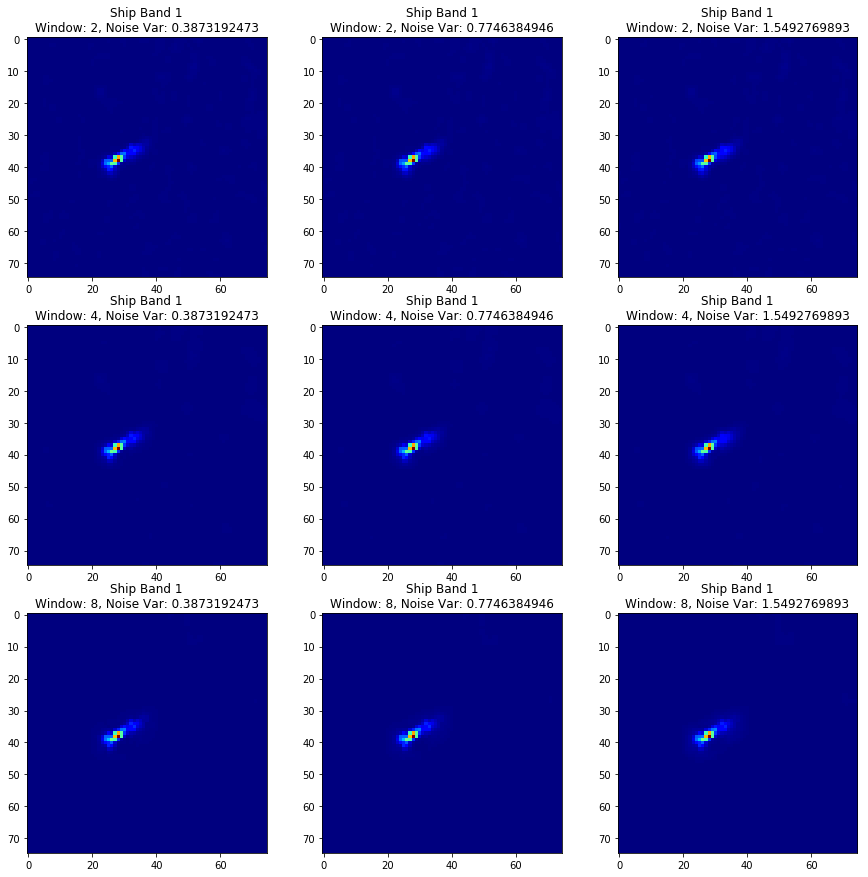

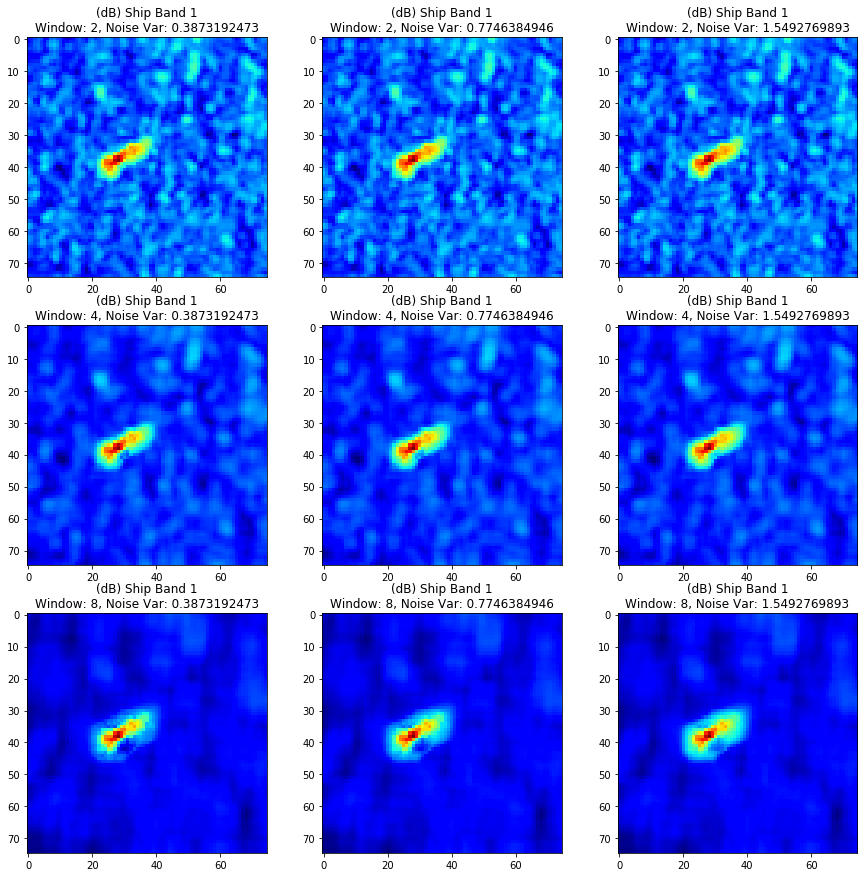

In [7]:
fig = plt.figure(2,figsize=(15,15))
p = 0
for i in range(3):
    for j in range(3):
        p+=1
        ax = fig.add_subplot(3,3,p)
        title = title_str_1.format(str(windows[i]), str(noise_var_1[j]))
        ax.set_title(title)
        ax.imshow(lee_filter(band_1_linear, windows[i], noise_var_1[j]),cmap='jet')    
plt.show()

fig = plt.figure(3,figsize=(15,15))
p = 0
for i in range(3):
    for j in range(3):
        p+=1
        ax = fig.add_subplot(3,3,p)
        title = title_str_1.format(str(windows[i]), str(noise_var_1[j]))
        ax.set_title('(dB) ' + title)
        ax.imshow(linear_to_decibel(lee_filter(band_1_linear, windows[i], noise_var_1[j])),cmap='jet')    
plt.show()

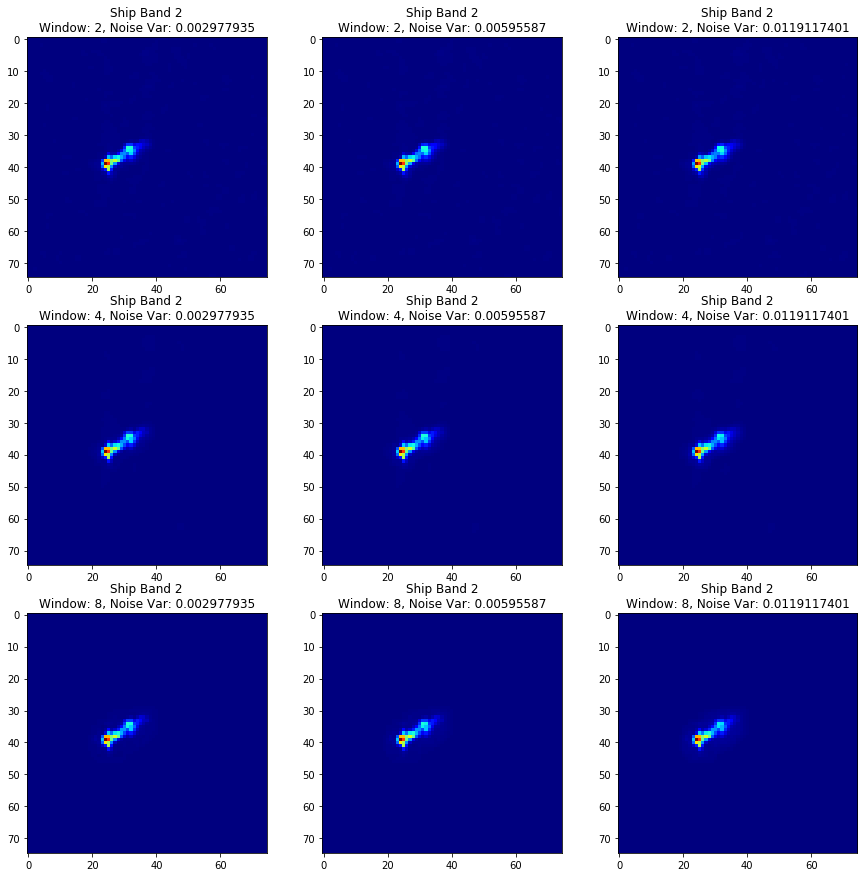

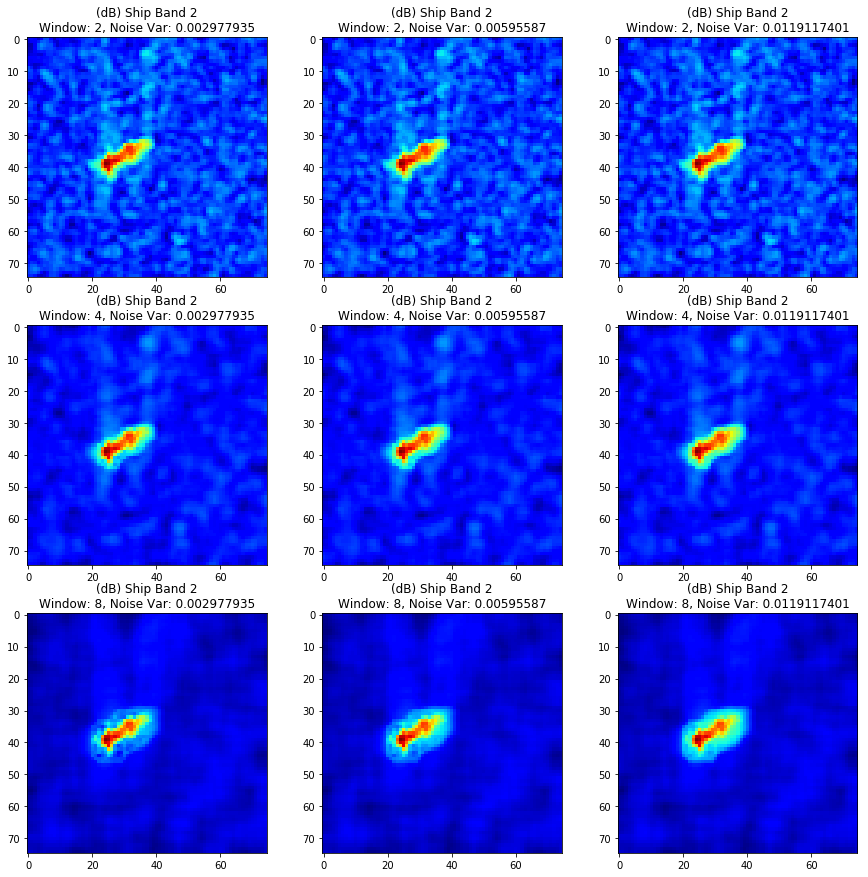

In [8]:
fig = plt.figure(4,figsize=(15,15))
p = 0
for i in range(3):
    for j in range(3):
        p+=1
        ax = fig.add_subplot(3,3,p)
        title = title_str_2.format(str(windows[i]), str(noise_var_2[j]))
        ax.set_title(title)
        ax.imshow(lee_filter(band_2_linear, windows[i], noise_var_2[j]),cmap='jet')    
plt.show()

fig = plt.figure(4,figsize=(15,15))
p = 0
for i in range(3):
    for j in range(3):
        p+=1
        ax = fig.add_subplot(3,3,p)
        title = title_str_2.format(str(windows[i]), str(noise_var_2[j]))
        ax.set_title('(dB) ' + title)
        ax.imshow(linear_to_decibel(lee_filter(band_2_linear, windows[i], noise_var_2[j])),cmap='jet')    
plt.show()